In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

Learn a simple 1d energy function using observations of optimal actions.

In [2]:
class Target():
    def __init__(self):
        # generate a random scalar function
        activation = tf.nn.selu
        self.fn = tf.keras.Sequential([
            tf.keras.layers.Dense(8, activation=activation),
            tf.keras.layers.Dense(8, activation=activation),
            tf.keras.layers.Dense(8, activation=activation),
            tf.keras.layers.Dense(1)
        ])

    def generate_batch(self, batch_size, step_size=1e-1):
        x = tf.random_uniform(minval=-3.0, maxval=3.0, shape=[batch_size, 1])
        y = self.fn(x)
        return x, x - step_size * tf.gradients(y, x)[0]

In [3]:
class EnergyDynamics(object):
    def __init__(self):
        activation = tf.nn.selu
        self.fn = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation=activation, input_shape=[1]),
            tf.keras.layers.Dense(256, activation=activation),
            tf.keras.layers.Dense(256, activation=activation),
            tf.keras.layers.Dense(1),
        ])

    def forward(self, x, step_size=1e-1):
        with tf.name_scope('energy_forward'):
            e = self.fn(x)
            return x - step_size * tf.gradients(e, x)[0]

    def get_loss(self, x, t):
        return tf.losses.mean_squared_error(self.forward(x), t)

In [4]:
### build the tf graph
target = Target()
x, x_t = target.generate_batch(128)

model = EnergyDynamics()
loss = model.get_loss(x, x_t)

X = tf.expand_dims(tf.linspace(-5.0, 5.0, 1000), 1)
Y = model.fn(X)
T = target.fn(X)

In [5]:
### boiler plate for tf
global_step = tf.train.get_or_create_global_step()
train_step = tf.train.AdamOptimizer().minimize(loss, var_list=model.fn.variables, global_step=global_step)

tf.summary.scalar('loss', loss)
summaries = tf.summary.merge_all()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter('/tmp/iul/0', sess.graph)

In [6]:
def plot(step, x, y, t):
    plt.figure()
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.plot(x, (y - y.mean())/t.var(), label='prediction')
    ax.plot(x, (t - t.mean())/t.var(), label='target')
    plt.legend()

def train(n_steps):
    for i in range(n_steps):
        summ, _, L, step = sess.run([summaries, train_step, loss, global_step])
        print('\rStep: {}, loss: {}'.format(step, L), end='', flush=True)
        writer.add_summary(summ, i)

<Figure size 432x288 with 0 Axes>

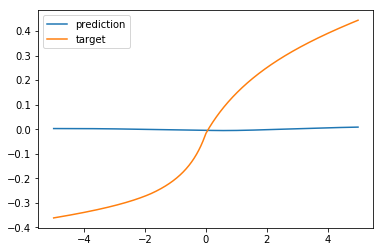

In [7]:
plot(*sess.run([global_step, X, Y, T]))

Step: 3000, loss: 3079411.2551255555455

<Figure size 432x288 with 0 Axes>

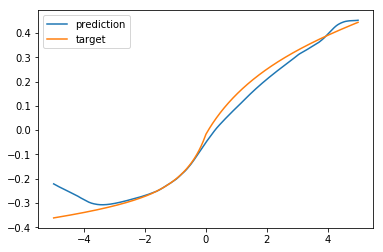

<Figure size 432x288 with 0 Axes>

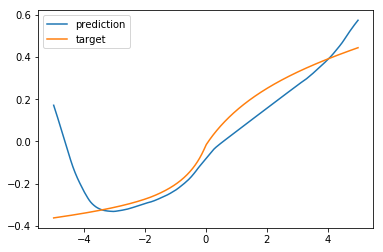

<Figure size 432x288 with 0 Axes>

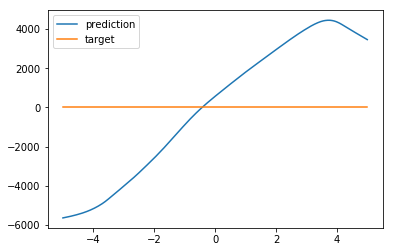

In [8]:
for _ in range(3):
    train(1000)
    plot(*sess.run([global_step, X, Y, T]))

Hmm. There are a couple of issues so far;

- it's quite unstable with respect to;
    - the type of non-linearity used,
    - the training length,
    - pretty much anything...
- we are sharing the step sizes. 